In [1]:
# Default Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

# Import environment from env.py
from env import action_outcome

# Import Q Learning function from Q_learning_fn.py
from Q_learning_fn import Q_learning

# Figure Formatting
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})
sns.set_style("whitegrid", {'axes.grid' : False})


# Part 1 - Defining the Classroom Environment
## Introduction

We formalise the problem into an example classroom with rows of students and a teacher. 

The teacher is the controller of the system and would like for the paper to be passed to him/her and placed into the recycling bin, not the general trash. More formally:

1. the paper should be passed along the class, 
2. in as few steps as possible, 
3. until it can be passed to the lecturer (controller) and will be placed in the bin. 

We first show this as a real diagram and then how this can be formalised into a 'Grid World' example. In this example, students A and M are 'risky' individuals in that there is a chance that they attempt to throw the paper. As before, each student may pass or hold onto the paper (denoted by actions that go into a wall).

### Formalising the MDP

The MDP for the environment is deﬁned by: 
- States are the students, teacher and the bin with 2-d(x,y) positions in the classroom
- Actions are commands given to each state and are deﬁned by \[up, down, left, right]
- The transition probability function is deﬁned by the probability each state object has for successfully following the given action.
- The reward function is simply deﬁned as +1 for reaching the positive goal, -1 for reaching the negative goal and a small negative reward (e.g. -0.04) otherwise to encourage decisions that lead to the positive goal


The probabilities are defined by:
- The next state will depend on the current \[x,y] state, action and probability distribution. If a “wall” is hit (e.g. C := \[2,1] and action “up”) then the next state will remain the same as the current state.
- The teacher will always follow their command.
- Other students have the probability of following the action set to 0.8 and 0.1 for every other action
- The episode ends when the paper reaches the bin.



![Real](https://i.imgur.com/nOIUKlg.png)

![GridWorld](https://i.imgur.com/WeJnqs2.png)

## Initialising the Environment

### States and Actions

- We initialise the states by manuall defining the state's names and \[x,y] coordinates.
- Possible actions are given as a choice from \['left','right','up','down']
- The reward signal to capture the terminal states with reward of +1 and -1
- An initial policy is set RANDOMLY as:
    - A = 'left'
    - B = 'up'
    - C = 'right'
    - D = 'up'
    - E = 'up'
    - F = 'right'
    - G = 'right'
    - T = 'right'
    - M = 'up'
    - recycling = 'up'
    - Trash = 'up'

In [3]:
# DEFINING ENVIRONMENT ELEMENTS
#------------------------------------------------------------------------------------------
# ENVIRONMENT REQUIREMENTS
## Define states with 1) Labels, 2) Rewards and 3) [x,y] coordinates
#     | ----------- |
#   3 |  F  G  T  r |
# Y 2 |  E  #  M  t |
#   1 |  D  C  B  A |
#     | ----------- |
#      1  2  3  4
#          X

# States are defined by a name and [x,y] coordinate
states = ['A','B','C','D','E','F','G','T','M','recycling','trash']
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

# The low-level actions the agent can make in the environment
actions = ['left','right','up','down']

# The reward signal to capture the terminal states with reward of +1 and -1
# A small negative reward is set for all other states to 'encourage' the agent towards the positive goal
# The index of this list aligns to the 'states' list given (e.g. moving into 'recycling' receives the reward '1')
rewards = [-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1,-1]

# A RANDOM initial policy is set
# The policy is the actions the agent should take in any given state
# The index of this list aligns to the 'states' list given (e.g. 'A' should pass the paper 'up')
initial_policy = ['left','up','right','up','up','right','right','right','up','up','up']

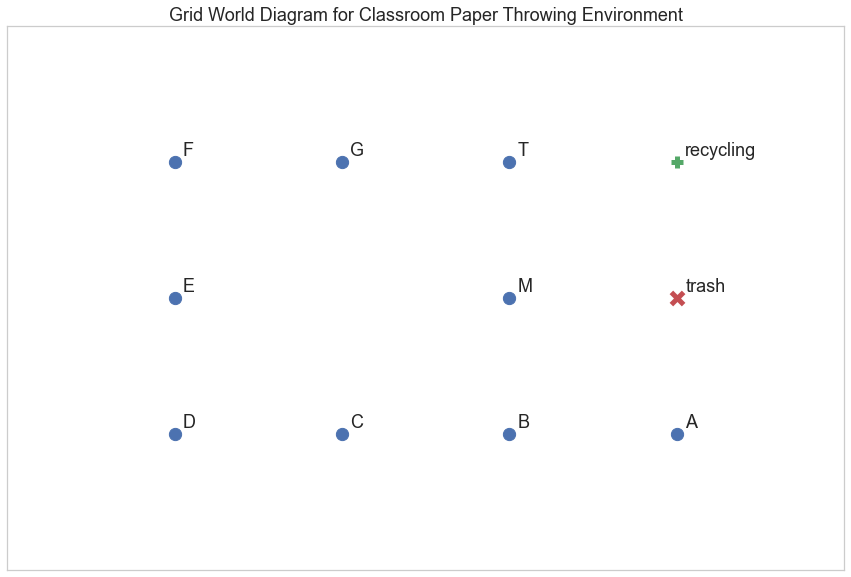

In [5]:
# Plotting the Initialised states by their [x,y] coordinates
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
plt.title("Grid World Diagram for Classroom Paper Throwing Environment")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


### Defining the Vector Outcome of Actions

#### Vector outcomes

- Given the state's \[x,y] coordinate, we need to define vector outcomes for the action given.
- For example, person 'A' passing the paper 'UP' will have the direction [0,1] to denote that the paper moves up in the y direction by 1.
- Likewise, 'C' passing left will have the direction \[-1,0] to denote that the paper moves left in x direction by 1.

#### Environment Boundary

- We also need to provide bounds of the positions to limit the size of the environment.
- Therefore, we override the action if it 'hits a wall'.
- For example, person 'A' passing left would hit the boundary and stay in 'A' for that action.


In [6]:
def action_outcome(state_x,state_y,action):
    if action == 'left':
        u = -1
        v = 0
    elif action == 'right':
        u = 1
        v = 0
    elif action == 'up':
        u = 0
        v = 1
    elif action == 'down':
        u = 0
        v = -1
    else:
        print("Error: Invalid action given")
        
    # Override if action hits wall to not move
    if (state_x == 1) & (u == -1):
        u = 0
        v = v
    elif (state_x == 4) & (u == 1):
        u = 0
        v = v
    elif (state_y == 1) & (v == -1):
        u = u
        v = 0
    elif (state_y == 3) & (v == 1):
        u = u
        v = 0
    elif (state_x == 2)&(state_y == 1) & (v == 1):
        u = u
        v = 0
    elif (state_x == 1)&(state_y == 2) & (u == 1):
        u = 0
        v = v  
    elif (state_x == 2)&(state_y == 3) & (v == -1):
        u = u
        v = 0         
    elif (state_x == 3)&(state_y == 2) & (u == -1):
        u = 0
        v = v 
    # Make so it cannot get out of bin
    elif (state_x == 4)&(state_y == 3):
        u = 0
        v = 0
    elif (state_x == 4)&(state_y == 2):
        u = 0
        v = 0
    return(u,v)

### The State-Action Pairs

- Given we have now defined the states and actions, we can produce a list of all the outcomes for each state.
- We can also plot these outcomes to show the possible passing directions.

In [8]:
state_action_pairs = pd.DataFrame()
for n1,state in enumerate(states):
    action_list = pd.DataFrame()
    for n2,action in enumerate(actions):
        
        state_x = x_list[n1]
        state_y = y_list[n1]
        u = action_outcome(state_x,state_y,action)[0]
        v = action_outcome(state_x,state_y,action)[1]
        action_list  = action_list.append(pd.DataFrame({'state':state,'action':action,'x':x_list[n1],'y':y_list[n1],
                                                               'u':u,'v':v}, index=[(n1*len(actions)) + n2]))
    
    state_action_pairs = state_action_pairs.append(action_list)
state_action_pairs.head(10)

,state,action,x,y,u,v
0,A,left,4,1,-1,0
1,A,right,4,1,0,0
2,A,up,4,1,0,1
3,A,down,4,1,0,0
4,B,left,3,1,-1,0
5,B,right,3,1,1,0
6,B,up,3,1,0,1
7,B,down,3,1,0,0
8,C,left,2,1,-1,0
9,C,right,2,1,1,0


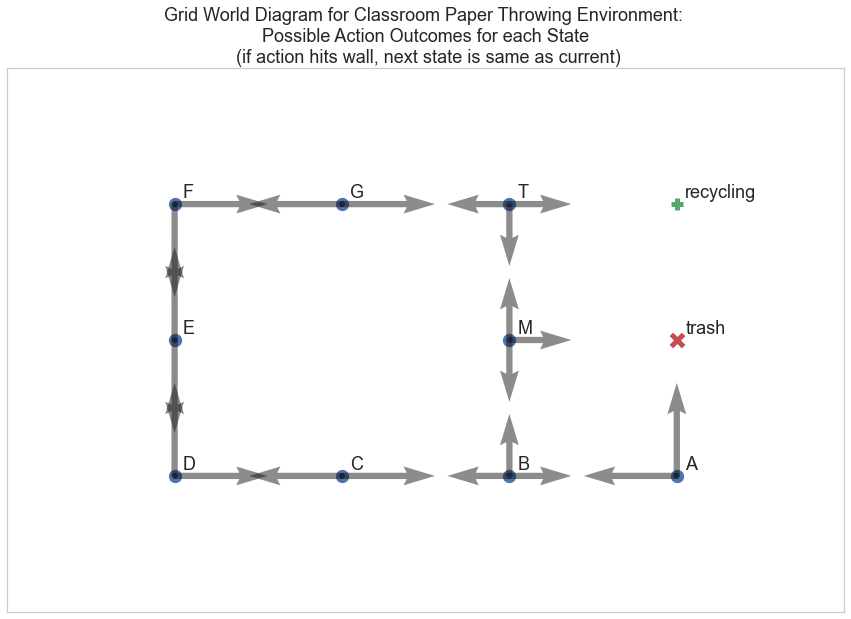

In [11]:
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    
    state_action_pairs_state = state_action_pairs[state_action_pairs['state']==state]
    plt.quiver([x_list[n],x_list[n],x_list[n],x_list[n]],[y_list[n],y_list[n],y_list[n],y_list[n]],
               state_action_pairs_state['u'],state_action_pairs_state['v'], alpha = 0.5)
    
plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Possible Action Outcomes for each State \n (if action hits wall, next state is same as current)")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


### The Initial Policy

- We can also filter this just for the randomised initial policy given previously.

In [14]:
initial_policy_table = pd.DataFrame()

for n,state in enumerate(states):
    state_x = x_list[n]
    state_y = y_list[n]
    policy_a = initial_policy[n]
    
    u = action_outcome(state_x,state_y,policy_a)[0]
    v = action_outcome(state_x,state_y,policy_a)[1]
    
    initial_policy_table = initial_policy_table.append(pd.DataFrame({'state':state,'x':state_x,'y':state_y, 'action':policy_a,
                                                                       'u':u,'v':v}, index=[n]))
initial_policy_table

,state,x,y,action,u,v
0,A,4,1,left,-1,0
1,B,3,1,up,0,1
2,C,2,1,right,1,0
3,D,1,1,up,0,1
4,E,1,2,up,0,1
5,F,1,3,right,1,0
6,G,2,3,right,1,0
7,T,3,3,right,1,0
8,M,3,2,up,0,1
9,recycling,4,3,up,0,0


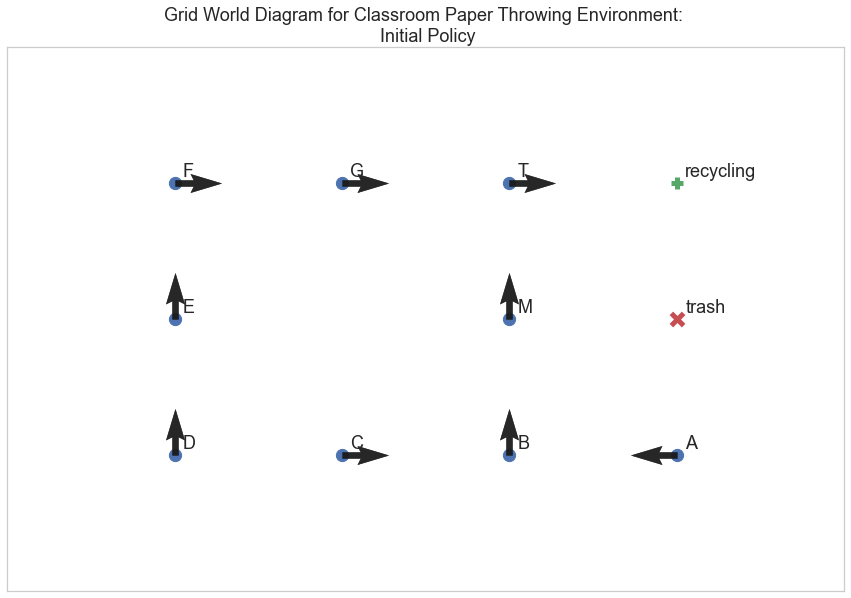

In [15]:
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    
    initial_policy_table_state = initial_policy_table[initial_policy_table['state']==state]
    plt.quiver([x_list[n],x_list[n],x_list[n],x_list[n]],[y_list[n],y_list[n],y_list[n],y_list[n]],
               initial_policy_table_state['u'],initial_policy_table_state['v'], alpha = 0.5)
    
plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Initial Policy")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


## Defining the Probabilistic Environment

- Following our introduction to the problem, we need to consider that each state represents a real person and therefore a command (or action) will not always have guaranteed outcomes. 
- Instead, we manually define the behaviour of each person into a single probability that summarises each person's likelihood to follow the given command (or action).
    - For example, the Teacher-'T' has a probability of 1 (guaranteed) to follow a command.
    - But person 'M' has a probability of 0.7 to follow a command.
    - NOTE: Reducing their behaviour in this way is done for simplity, it may be considered that a person may respond differently to different commands. 
- These probabilities create a simulator and we use a random number generator (RNG) to test whether each action will be followed.
- If the action is not followed, a random alternative outcome is produced instead. 
    - For example, if 'M' does not follow the comman 'UP' then a radom outcome of 'LEFT', 'DOWN' or 'RIGHT' is produced. 

### Function description

INPUTS: State Name and Action

1. Outcome probabilities manually defined
2. Simulate whether action is followed given the probability
3. Take the outcome and return the required information:
    1. Lookup state's \[x,y] coordinates
    2. Find the vector outcome
    3. Returns index of x + y position to then find the name of the resultant next state
    4. Lookupt reward given the next state
4. Return:
    - the initial state (name & \[x,y]) and action, 
    - the action's outcome direction under the simulation probabilty
    - the next state (name and \[x,y])
    - the immediate reward




In [16]:
# INPUTS: State Name and Action
def environment(state, action):
    # Outcome probabilities manually defined
    if (state=='recycling')|(state=='trash'):
        prob = 0
    elif (state=='T'):
        prob = 1

    elif (state=='M'):
        prob = 0.7
   
    elif (state=='B'):
        prob = 0.7

    elif (state=='A'):
        prob = 0.7

    elif (state=='C'):
        prob = 0.7

    elif (state=='D'):
        prob = 0.7

    elif (state=='E'):
        prob = 0.7

    elif (state=='F'):
        prob = 0.7

    elif (state=='G'):
        prob = 0.7

    else:
        # Simple error exception
        prob = "Error"
        print("Error state", state)

    # Simulate whether action is followed given the probability
    action_rng = np.random.rand()
    if action_rng<=prob:
        action = action
    else:
        action_sub_list = actions.copy()
        action_sub_list.remove(action)
        action = random.choice(action_sub_list)
        
    # Take the outcome and return the required information
    ## Lookup state's [x,y] coordinates
    state_x = x_list[states.index(state)]
    state_y = y_list[states.index(state)]

    ## Find the vector outcome
    u = action_outcome(state_x,state_y,action)[0]
    v = action_outcome(state_x,state_y,action)[1]
    next_state_x = state_x + u
    next_state_y = state_y + v

    ## Returns index of x + y position to then find the name of the resultant next state
    next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]

    ## Lookupt reward given the next state
    reward = rewards[states.index(next_state)]

    # Return:
    # - the initial state (name & [x,y]) and action, 
    # - the action's outcome direction under the simulation probabilty
    # - the next state (name and [x,y])
    # - the immediate reward
    return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)

### Testing the Simulator

- We can test the outcome of a single action in a state being repeated.
- Person 'A' generall follows the action given with occasional random outcomes as we would expect from a 0.7 probability.

In [22]:
for i in range(0,10):
    print(environment('A', 'left'))

('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'down', 4, 1, 0, 0, 'A', 4, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'right', 4, 1, 0, 0, 'A', 4, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'down', 4, 1, 0, 0, 'A', 4, 1, -0.04)
('A', 'up', 4, 1, 0, 1, 'trash', 4, 2, -1)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)


## Conclusion

- The environment is now defined ready to be used for RL as we have a simulator that produces the outcome and immediate reward of actions in each state.